# 01 - Data Preparation

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
sys.path.append('../')
import src

## Format asset data

In [9]:
first_year = 1993
last_year = 2019
for year in range(first_year, last_year+1):
    src.preprocess.preprocess_year(year, last_year=(year==last_year))
    print('processed sampling year {}'.format(year))

processed sampling year 1993
processed sampling year 1994
processed sampling year 1995
processed sampling year 1996
processed sampling year 1997
processed sampling year 1998
processed sampling year 1999
processed sampling year 2000
processed sampling year 2001
processed sampling year 2002
processed sampling year 2003
processed sampling year 2004
processed sampling year 2005
processed sampling year 2006
processed sampling year 2007
processed sampling year 2008
processed sampling year 2009
processed sampling year 2010
processed sampling year 2011
processed sampling year 2012
processed sampling year 2013
processed sampling year 2014
processed sampling year 2015
processed sampling year 2016
processed sampling year 2017
processed sampling year 2018
processed sampling year 2019


## Process factor data

In [10]:
src.preprocess.preprocess_ff_factors()

In [11]:
src.preprocess.preprocess_spy()

## Process descriptive data

In [12]:
df_descriptive = pd.read_pickle('../data/raw/descriptive.pkl')
df_descriptive.to_csv('../data/processed/descriptive.csv')

# OLD

## Load raw data

In [2]:
df_crsp_raw = pd.read_pickle('../data/raw/df_crsp_raw.pkl')

In [3]:
df_crsp_delist = pd.read_pickle('../data/raw/df_crsp_delist.pkl')

In [4]:
df_crsp_desc = pd.read_pickle('../data/raw/df_crsp_desc.pkl')

In [5]:
df_ff_raw = pd.read_pickle('../data/raw/df_ff_raw.pkl')

## Format FF data

In [6]:
# edit data formats
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)

# declare index
df_ff_raw.set_index('date', inplace=True)

In [7]:
df_ff_raw.to_pickle(path='../data/interim/df_ff.pkl')

## Transform CRSP data to tidy data format & adjust returns for delisting

In [6]:
df_crsp_tidy = df_crsp_raw.reset_index()
del df_crsp_raw

In [7]:
# edit data formats
df_crsp_tidy['date'] = pd.to_datetime(df_crsp_tidy['date'], yearfirst=True)
df_crsp_tidy[['permno']] = df_crsp_tidy[['permno']].astype(int)

df_crsp_delist['permno'] = df_crsp_delist['permno'].astype(int)
df_crsp_delist['date'] = pd.to_datetime(df_crsp_delist['date'], yearfirst=True)

In [8]:
# merge
df_crsp_tidy = df_crsp_tidy.merge(df_crsp_delist, how='left', on=['permno','date'])

In [9]:
# adjusted returns (for delisting)
df_crsp_tidy['retadj'] = (1+df_crsp_tidy['ret'].fillna(0))*(1+df_crsp_tidy['dlret'].fillna(0))-1
df_crsp_tidy['retadj'] = df_crsp_tidy['retadj'].where(df_crsp_tidy['ret'].notna() | df_crsp_tidy['dlret'].notna())

In [10]:
# declare index & sort
df_crsp_tidy.set_index(['date','permno'], inplace=True)
df_crsp_tidy = df_crsp_tidy.drop(columns=['index', 'dlret'])
df_crsp_tidy = df_crsp_tidy.sort_index()

In [13]:
df_crsp_tidy.to_pickle(path='../data/interim/df_crsp_tidy.pkl')

## Format descriptive data

In [12]:
df_crsp_desc['permno'] = df_crsp_desc['permno'].astype(int)
df_aux = df_crsp_desc\
                    .groupby('permno')\
                    .last()

In [15]:
df_aux.to_pickle(path='../data/interim/df_aux.pkl')

## Filter biggest Assets per Year

In [16]:
# TEMPORARY CELL
df_crsp_tidy = pd.read_pickle('../data/interim/df_crsp_tidy.pkl')
df_aux = pd.read_pickle('../data/interim/df_aux.pkl')

In [13]:
# parameters
N_LARGEST = 100
ESTIMATION_YEARS = 1
ANALYSIS_YEARS = 1

In [14]:
# select years
sample_years = list(df_crsp_tidy.index.get_level_values('date').year.unique())
if (df_crsp_tidy.index.get_level_values('date').year==sample_years[0]).sum() < (df_crsp_tidy.index.get_level_values('date').year==sample_years[1]).sum()*0.5:
    sample_years = sample_years[1:]

In [19]:
# select assets function # PREVIOUSLY USED
def select_assets(df_estimation, n_assets):
    year_obs = len(df_estimation['ret'].unstack())
    
    df_select = pd.DataFrame()
    df_select['full_year'] = df_estimation['retadj']\
                                .groupby('permno')\
                                .count() > year_obs*0.99
    df_select['size'] = df_estimation['mcap']\
                                .unstack()\
                                .sort_index()\
                                .fillna(method='ffill', limit=1)\
                                .tail(1)\
                                .squeeze()
    df_select['size_rank'] = df_select['size']\
                                .where(df_select['full_year'])\
                                .rank(ascending=False)
    
    selected_assets = list(df_select.index[df_select['size_rank'] <= n_assets])
    return selected_assets

In [16]:
# select assets function
def select_assets(df_estimation, df_analysis, n_assets):
    year_obs = len(df_estimation['ret'].unstack())
    
    df_select = pd.DataFrame()
    df_select['full_obs'] = df_estimation['retadj']\
                                .groupby('permno')\
                                .count() > year_obs*0.99
    df_select['subsequent_obs'] = df_analysis['ret']\
                                .groupby('permno')\
                                .count() > 0
    df_select['size'] = df_estimation['mcap']\
                                .unstack()\
                                .sort_index()\
                                .fillna(method='ffill', limit=1)\
                                .tail(1)\
                                .squeeze()
    df_select['size_rank'] = df_select['size']\
                                .where(df_select['full_obs'])\
                                .where(df_select['subsequent_obs'])\
                                .rank(ascending=False)
    
    selected_assets = list(df_select.index[df_select['size_rank'] <= n_assets])
    return selected_assets

In [20]:
# PREVIOUSLY USED
df_estimation_tidy = pd.Series(dtype='float', index=pd.MultiIndex.from_arrays([[],[]]))
df_analysis_tidy = pd.Series(dtype='float', index=pd.MultiIndex.from_arrays([[],[]]))
df_indices = pd.DataFrame()

for year in sample_years[ESTIMATION_YEARS-1:-ANALYSIS_YEARS]:
    # slice time dime dimension
    df_estimation = df_crsp_tidy[(df_crsp_tidy.index.get_level_values('date').year > year-ESTIMATION_YEARS)\
                                      & (df_crsp_tidy.index.get_level_values('date').year <= year)]
    df_analysis = df_crsp_tidy[(df_crsp_tidy.index.get_level_values('date').year > year)\
                                      & (df_crsp_tidy.index.get_level_values('date').year <= year+ANALYSIS_YEARS)]

    # slice assets
    selected_assets = select_assets(df_estimation, df_analysis, N_LARGEST)
    df_estimation = df_estimation[[i in selected_assets for i in df_estimation.index.get_level_values('permno')]]
    df_analysis = df_analysis[[i in selected_assets for i in df_analysis.index.get_level_values('permno')]]

    # output adjusted returns data
    df_estimation = df_estimation['retadj'].unstack().fillna(0)
    df_analysis = df_analysis['retadj'].unstack()
    df_descriptive = df_aux.loc[selected_assets]
    
    # save
    df_estimation.to_csv('../data/processed/yearly/df_estimation_'+str(year)+'.csv')
    df_analysis.to_csv('../data/processed/yearly/df_analysis_'+str(year)+'.csv')
    df_descriptive.to_csv('../data/processed/yearly/df_descriptive_'+str(year)+'.csv')
    
    # collect full timeline
    df_estimation_tidy = df_estimation_tidy.append(df_estimation.stack())
    df_analysis_tidy = df_analysis_tidy.append(df_analysis.stack())
    df_indices[year] = selected_assets
    
    print(year, dt.datetime.today())

2000 2020-05-29 16:40:31.668072
2001 2020-05-29 16:40:49.310321
2002 2020-05-29 16:41:07.186422
2003 2020-05-29 16:41:24.240785
2004 2020-05-29 16:41:39.917360
2005 2020-05-29 16:41:55.490645
2006 2020-05-29 16:42:11.250323
2007 2020-05-29 16:42:29.128580
2008 2020-05-29 16:42:44.963894
2009 2020-05-29 16:42:59.626802
2010 2020-05-29 16:43:14.079632
2011 2020-05-29 16:43:28.883579
2012 2020-05-29 16:43:43.516411
2013 2020-05-29 16:43:59.139358
2014 2020-05-29 16:44:14.506369
2015 2020-05-29 16:44:29.569943
2016 2020-05-29 16:44:44.718138
2017 2020-05-29 16:44:59.806002
2018 2020-05-29 16:45:14.938846


In [97]:
# VOLA
df_estimation_tidy = pd.Series(dtype='float', index=pd.MultiIndex.from_arrays([[],[]]))
df_analysis_tidy = pd.Series(dtype='float', index=pd.MultiIndex.from_arrays([[],[]]))
df_indices = pd.DataFrame()

for year in sample_years[ESTIMATION_YEARS-1:-ANALYSIS_YEARS]:
    # slice time dime dimension
    df_estimation = df_crsp_tidy[(df_crsp_tidy.index.get_level_values('date').year > year-ESTIMATION_YEARS)\
                                      & (df_crsp_tidy.index.get_level_values('date').year <= year)]
    df_analysis = df_crsp_tidy[(df_crsp_tidy.index.get_level_values('date').year > year)\
                                      & (df_crsp_tidy.index.get_level_values('date').year <= year+ANALYSIS_YEARS)]

    # slice assets
    selected_assets = select_assets(df_estimation, df_analysis, N_LARGEST)
    df_estimation = df_estimation[[i in selected_assets for i in df_estimation.index.get_level_values('permno')]]
    df_analysis = df_analysis[[i in selected_assets for i in df_analysis.index.get_level_values('permno')]]

    # output adjusted returns data
    df_estimation = df_estimation['vola'].unstack().fillna(0)
    df_analysis = df_analysis['vola'].unstack()
    df_descriptive = df_aux.loc[selected_assets]
    
    # save
    df_estimation.to_csv('../data/processed/yearly/vola/df_est_'+str(year)+'.csv')
    df_analysis.to_csv('../data/processed/yearly/vola/df_ana_'+str(year)+'.csv')
    df_descriptive.to_csv('../data/processed/yearly/vola/df_descriptive_'+str(year)+'.csv')
    
    # collect full timeline
    df_estimation_tidy = df_estimation_tidy.append(df_estimation.stack())
    df_analysis_tidy = df_analysis_tidy.append(df_analysis.stack())
    df_indices[year] = selected_assets
    
    print(year, dt.datetime.today())

2000 2020-09-29 16:04:12.614764
2001 2020-09-29 16:04:29.995758
2002 2020-09-29 16:04:48.239813
2003 2020-09-29 16:05:07.591239
2004 2020-09-29 16:05:24.411406
2005 2020-09-29 16:05:41.613109
2006 2020-09-29 16:05:58.307471
2007 2020-09-29 16:06:14.879862
2008 2020-09-29 16:06:31.259079
2009 2020-09-29 16:06:47.054409
2010 2020-09-29 16:07:03.350584
2011 2020-09-29 16:07:19.036613
2012 2020-09-29 16:07:35.469889
2013 2020-09-29 16:07:51.815372
2014 2020-09-29 16:08:07.914728
2015 2020-09-29 16:08:23.864163
2016 2020-09-29 16:08:40.396845
2017 2020-09-29 16:08:55.895060
2018 2020-09-29 16:09:11.281512


In [21]:
df_estimation_tidy.to_pickle(path='../data/processed/df_estimation_data.pkl')
df_analysis_tidy.to_pickle(path='../data/processed/df_analysis_data.pkl')
df_indices.to_pickle(path='../data/processed/df_indices_data.pkl')

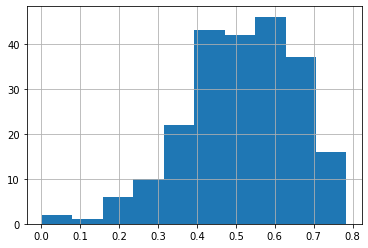

In [101]:
df_estimation_tidy.unstack()\
                  .apply(lambda x: x.autocorr(1))\
                  .hist()

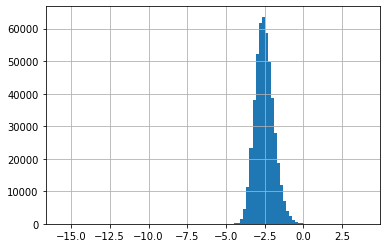

In [99]:
np.log((df_estimation_tidy.replace(0, 1e-8)**1*np.sqrt(250)))\
    .hist(bins=100)